# PAWS with SBI - Toy Studies

Application of the PAWS method with inference on analytic distributions and pseudo datasets

## Part I - Formulation

Let's begin with the basic principles of the PAWS method.

Given the feature vector $\vec{x}$ and the physics parameters $\theta$, the output the supervised classifier approximates the posterior probability of the signal ($y = 1$):

$$f_{\text{FS}}(\vec{x}, \theta) \approx \frac{P_S(\vec{x}|\theta)P_S(\theta)}{P_S(\vec{x}|\theta)P_S(\theta) + P_B(\vec{x}|\theta)P_B(\theta)}$$

where $S$ = Signal ($y = 1$) and $B$ = Background ($y = 0$).

The likelihood ratio is then given by

$$\Lambda_{\text{FS}}(\vec{x}, \theta) \equiv \frac{P_S(\vec{x}|\theta)}{P_B(\vec{x}|\theta)} = \kappa(\theta) \frac{f_{\text{FS}}(\vec{x}, \theta)}{1 - f_{\text{FS}}(\vec{x}, \theta)}$$

where $\kappa(\theta) \equiv P_B(\theta) / P_S(\theta)$ ratio between the background and signal priors for a given $\theta$. It roughly corresponds to the ratio between the number of backgrounds and that of signal at a given $\theta$.

Similarly for the weakly supervised model:

$$f_{\text{WS}}(\vec{x}, \theta) = \frac{P_D(\vec{x}|\theta)P_D(\theta)}{P_D(\vec{x}|\theta)P_D(\theta) + P_R(\vec{x}|\theta)P_R(\theta)}$$

where $D$ = Data and $R$ = Reference (= Background).

Observe that when $\theta = \hat{\theta}$ the data densities can be expressed in terms of the signal and background densities:

$$P_D(\vec{x}) = \mu P_S(\vec{x}) + (1 - \mu) P_B(\vec{x})$$

Suppose the number of background events in the data and reference samples are equal. The prior probabilities of data $P_D$ and reference $P_R$ can be related by:

$$P_D = P_S + P_B = \frac{\mu}{1 - \mu} P_R + P_R = \frac{1}{1 - \mu} P_R$$

Putting these together, we can now express $\text{WS}(\vec{x}, \theta)$ in terms of $\text{FS}(\vec{x}, \theta)$

$$f_{\text{WS}}(\vec{x}, \theta) = \dfrac{\mu\kappa(\theta)\dfrac{f_{\text{FS}}(\vec{x}, \theta)}{1 - f_{\text{FS}}(\vec{x}, \theta)} + (1 - \mu)}{\mu\kappa(\theta)\dfrac{f_{\text{FS}}(\vec{x}, \theta)}{1 - f_{\text{FS}}(\vec{x}, \theta)} + 2(1-\mu)} = \dfrac{\mu\Lambda_{\text{FS}}(\vec{x}, \theta) + (1 - \mu)}{\mu\Lambda_{\text{FS}}(\vec{x}, \theta) + 2(1-\mu)} $$

---

Now, we want to apply PAWS to **simulation-based inference (SBI)**.

Given the probability density for data with feature vector $\vec{x}$ and parameters $\boldsymbol{\theta}$

$$P_{\mathcal{D}}(\vec{x}|\boldsymbol{\theta}) = \mu P_{\mathcal{S}}(\vec{x}|\boldsymbol{\theta}') + (1 - \mu) P_{\mathcal{B}}(\vec{x})$$

where $\boldsymbol{\theta} = \boldsymbol{\theta}' \cup \{\mu, \alpha\}$

We can define the likelihood function as the joint pdf over the data sample (size $n$)

$$L(\boldsymbol{\theta}) = f_{\mathcal{D}}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_n|\boldsymbol{\theta}) = \prod_{i=1}^{n} P_{\mathcal{D}}(\vec{x}_i|\boldsymbol{\theta})$$

For convenience, we work with the log-likehood function  
    
$$\ell(\boldsymbol{\theta}) = \log L(\boldsymbol{\theta}) = \sum_{i=1}^{n} \log P_{\mathcal{D}}(\vec{x}_i|\boldsymbol{\theta})$$

The maximum likelihood estimate (MLE) $\hat{\boldsymbol{\theta}}$ is the value of $\theta$ that maximizes the likelihood
        
$$\hat{\theta} = \arg \max_{\theta} \ell(\boldsymbol{\theta})$$

We can relate $\ell(\boldsymbol{\theta})$ to $\Lambda_{\text{FS}}(\vec{x}_i, \theta)$ by considering

$$\begin{align*}
    \ell(\boldsymbol{\theta}) &= \sum_{i=1}^{n} \log P_{\mathcal{D}}(\vec{x}_i|\boldsymbol{\theta}) \\
    & \sim  \sum_{i=1}^{n} \log \frac{P_{\mathcal{D}}(\vec{x}_i|\boldsymbol{\theta})}{P_{\mathcal{B}}(\vec{x}_i)} \\
    &= \sum_{i=1}^{n} \log [\mu \Lambda_{\text{FS}}(\vec{x}_i, \theta) + (1 - \mu)]
\end{align*}$$

Notice we can scale by a factor $P_{\mathcal{B}}(\vec{x}_i)$ without changing the maximum likelihood given it's independent of $\boldsymbol{\theta}$.

In ML, we usual do minimization of the loss function, in this case we want to minimize the negative log-likelihood

$$\text{NLLLoss} = - \sum_{i=1}^{n} \log [\mu \Lambda_{\text{FS}}(\vec{x}_i, \theta) + (1 - \mu)]$$

Now, we can evaluate the confidence interval of the predicted parameter value by using the profile likelihood

First, we compute the likelihood ratio

$$\mathcal{L}(\theta) = -2 \log\frac{L(\theta)}{L(\hat{\theta})} = - 2 \left[\ell(\theta) - \ell(\hat{\theta})\right]$$

By the Wilk's theorem, the likelihood ratio $\mathcal{L}(\theta)$ asymptotically follows a $\chi_k^2$ distribution (true for large sample size).

Here the dof $k$ correspond to the number of parameters being tested.

To find the CI, we find the values of $\theta$ where $\mathcal{L}(\theta)$ equals the critical value of the $\chi_k^2$ distribution. The interval of $\theta$ is then given by

$$\mathcal{L}(\theta) \leq \chi_{\alpha, k}^2$$

## Part II - Demonstration

In [33]:
import sys
from collections import defaultdict
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import multivariate_normal, expon
from scipy.optimize import minimize, minimize_scalar

In [141]:
def get_intervals(x:np.ndarray, y:np.ndarray, level:float, delta:float=0.0001):
    from scipy.interpolate import interp1d
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]
    func_interp = interp1d(x, y, fill_value="extrapolate")
    x_interp = np.arange(min(x), max(x), delta)
    y_interp = func_interp(x_interp)
    # remove points that are nan
    mask = np.argwhere(~np.isnan(y_interp))
    x_interp = x_interp[mask]
    y_interp = y_interp[mask]
    asign = np.sign(y_interp - level)
    sign_change   = (np.roll(asign, 1) - asign) != 0
    # first point can not have a sign change
    sign_change[0][0] = False
    intersections = x_interp[sign_change]
    sign_slope    = asign[sign_change]
    # no intersections
    if len(intersections) == 0:
        return []
    if len(intersections) == 1:
        if sign_slope[0] == -1:
            return np.array([[intersections[0], np.inf]])
        else:
            return np.array([[-np.inf, intersections[0]]])
    else:
        if sign_slope[0] == 1:
            intersections = np.insert(intersections, 0, -np.inf)
        if sign_slope[-1] == -1:
            intersections = np.insert(intersections, intersections.shape[0], np.inf)
        if len(intersections) & 1:
            raise RuntimeError("number of intersections can not be odd")
        n_pairs = len(intersections) // 2
        return intersections.reshape((n_pairs, 2))
        
class Demonstrator:
    
    def __init__(self, model_S, model_B):
        self.model_S = model_S
        self.model_B = model_B

    def get_random_state(self, seed=None):
        return np.random.RandomState(seed) if seed is not None else None

    def get_R(self, N_B: int , seed=None):
        random_state = self.get_random_state(seed)
        return self.model_B.rvs(size=N_B, random_state=random_state)

    def get_D(self, N_B: int, mu_inj: float, seed=None):
        N_S = int(mu_inj / (1 - mu_inj) * N_B)
        random_state = self.get_random_state(seed)
        return np.concatenate([self.model_S.rvs(size=N_S, random_state=random_state),
                               self.model_B.rvs(size=N_B, random_state=random_state)])

    def get_dataset(self, N_B: int, mu_inj: float, seed=None):
        R = self.get_R(N_B, seed=seed)
        D = self.get_D(N_B, mu_inj, seed=seed)
        y = np.concatenate([np.ones(D.shape[0]), np.zeros(R.shape[0])])
        x = np.concatenate([D, R])
        return x, y
        
    def get_pS_over_pB(self, x):
        return self.model_S.pdf(x) / self.model_B.pdf(x)

    def get_lambda_FS(self, x):
        return self.get_pS_over_pB(x)

    def get_FS(self, x):
        pS_over_pB = self.get_pS_over_pB(x)
        return pS_over_pB / (1 - pS_over_pB)

    def get_WS(self, x, mu):
        pS_over_pB = self.get_pS_over_pB(x)
        return (mu * pS_over_pB + 1 - mu) / (mu * pS_over_pB + 2 - 2 * mu)

    def get_nll(self, x, y, mu):
        lambda_FS = self.get_lambda_FS(x)
        nll = - y * np.log(mu * lambda_FS + 1 - mu)
        return nll

    def get_bce(self, x, y, mu):
        ws = self.get_WS(x, mu)
        overflow = (1 - ws) <= 0.
        underflow = ws <= 0.
        ws[overflow] = 1 - 1e-6
        ws[underflow] = 1e-6
        return - y * np.log(ws) - (1 - y) * np.log(1. - ws)

    def get_loss(self, x, y, mu, metric: str = 'nll'):
        if metric == 'nll':
            nll = self.get_nll(x, y, mu)
            return np.sum(nll)
        elif metric == 'bce':
            bce = self.get_bce(x, y, mu)
            return np.mean(bce)
        raise ValueError(f'unknown metric: {metric}')

    def loss_scan(self, x, y, mu_values, metric: str = 'nll'):
        result = []
        for mu in mu_values:
            result.append({
                'mu': mu,
                'loss': self.get_loss(x, y, mu, metric=metric)
            })
        return result

    def minimize_instance(self, mu_inj:float, trial:int, N_B: int, metric: str = 'nll'):
        sys.stdout.write(f'Running trial {trial + 1} with mu = {mu_inj}\n')
        x, y = self.get_dataset(N_B, mu_inj, seed=trial)
        func = lambda mu : self.get_loss(x, y, mu, metric)
        result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
        mu_hat = result.x
        return mu_inj, mu_hat

    def scan_mu_hat(self, mu_values, N_B, N_trial, metric: str = 'nll', max_workers=None):
        mu_args = np.repeat(mu_values, N_trial)
        trial_args = np.tile(np.arange(N_trial), len(mu_args))
        outputs = []
        if max_workers == 0:
            for mu, trial in zip(mu_args, trial_args):
                outputs.append(self.minimize_instance(mu, trial, N_B, metric=metric))
        else:
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                outputs = list(executor.map(self.minimize_instance, mu_args, trial_args, repeat(N_B), repeat(metric)))
        outputs = np.array(outputs)
        result = defaultdict(list)
        for output in outputs:
            result[output[0]].append(output[1])
        return result

    def plot_distribution(self, D, R, feature_index: int = 0, bin_range=(0, 20)):
        plt.hist(R[:, feature_index], alpha=0.5, range=bin_range, bins=40, label='Reference')
        plt.hist(D[:, feature_index], alpha=0.5, range=bin_range, bins=40, label='Data')
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('count')

    def plot_mu_hat(self, data, title: str = ''):
        mu_trues = np.array(list(data))
        mu_hats = np.array([values for values in data.values()])
        mu_mean = np.mean(mu_hats, axis=1)
        mu_std = np.std(mu_hats, axis=1)
        plt.fill_between(mu_trues, mu_mean - mu_std, mu_mean + mu_std, alpha=0.2)
        plt.plot(mu_trues, mu_mean)
        plt.plot(mu_trues, mu_trues, linestyle=":", color="gray")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel(r"True $\mu$")
        plt.ylabel(r"Fitted $\mu$")
        plt.title(title)
        plt.show()

    def plot_interval(self, data, threshold: float = 10, title: str = ''):
        df = pd.DataFrame(data)
        df['qmu'] = 2 * (df['loss'] - df['loss'].min())
        df = df[df['qmu'] < threshold].reset_index(drop=True)
        x, y = df['mu'].values, df['qmu'].values
        plt.plot(df['mu'], df['qmu'])
        ax = plt.gca()
        transform = matplotlib.transforms.blended_transform_factory(ax.transAxes, ax.transData)
        ax.hlines([1, 4], xmin=0, xmax=1, zorder=0, transform=transform,
                  color='gray', linestyle='--')
        ax.text(x=0.98, y=1 + 0.3, s=r'1 $\sigma$', ha='right', color='gray', transform=transform)
        ax.text(x=0.98, y=4 + 0.3, s=r'2 $\sigma$', ha='right', color='gray', transform=transform)
        ax.set_ylim(0, threshold * 1.2)
        intervals = {
            r'1 $\sigma$': get_intervals(x, y, 1),
            r'2 $\sigma$': get_intervals(x, y, 4)
        }
        dy = 0.05
        loc = (0.25, 0.5)
        dp = 5
        for i, (sigma_label, interval) in enumerate(intervals.items()):
            interval_str = r" \cup ".join([f"[{lo:.{dp}f}, {hi:.{dp}f}]" for (lo, hi) in interval])
            text = r'{sigma_label}: {xlabel}$\in {interval}$'.format(sigma_label=sigma_label, xlabel=r'$\mu$',
                                                                     interval=interval_str)
            ax.annotate(text, (loc[0], loc[1] - (i + 1) * dy),
                        xycoords='axes fraction')
        bestfit = df.loc[df['loss'].argmin()]['mu']
        text = r'Best fit: $\mu$ = {bestfit:.5f}'.format(bestfit=bestfit)
        loc = (0.25, 0.5)
        ax.annotate(text, loc, xycoords='axes fraction')
        plt.xlabel(r"$\mu$")
        plt.ylabel(r"$-2\Delta ln(L)$")
        plt.title(title)
        plt.show()

### Analytic Distributions - 1D Gaussian

In [100]:
seed = 2024
mu_S = 3
mu_B = 6
sigma = 1

model_S = multivariate_normal(mean=mu_S, cov=sigma, seed=seed)
model_B = multivariate_normal(mean=mu_B, cov=sigma, seed=seed)

demo = Demonstrator(model_S=model_S, model_B=model_B)

Maximum likelihood estimate for $\mu$

In [111]:
mu_inj_list = np.logspace(-2, -0.3, 10)
N_trial = 20
N_B = 100_000
mu_hat_data = demo.scan_mu_hat(mu_inj_list, N_B=N_B, N_trial=N_trial, metric='nll', max_workers=24)

Running trial 1 with mu = 0.01
Running trial 8 with mu = 0.01
Running trial 2 with mu = 0.01
Running trial 3 with mu = 0.01
Running trial 4 with mu = 0.01
Running trial 5 with mu = 0.01
Running trial 6 with mu = 0.01
Running trial 7 with mu = 0.01
Running trial 9 with mu = 0.01
Running trial 10 with mu = 0.01
Running trial 11 with mu = 0.01
Running trial 12 with mu = 0.01
Running trial 13 with mu = 0.01
Running trial 14 with mu = 0.01
Running trial 15 with mu = 0.01
Running trial 1 with mu = 0.015448591479026755
Running trial 2 with mu = 0.015448591479026755
Running trial 16 with mu = 0.01
Running trial 17 with mu = 0.01
Running trial 4 with mu = 0.015448591479026755
Running trial 18 with mu = 0.01
Running trial 3 with mu = 0.015448591479026755
Running trial 19 with mu = 0.01
Running trial 20 with mu = 0.01


/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; default

Running trial 5 with mu = 0.015448591479026755


/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)


Running trial 6 with mu = 0.015448591479026755


/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)


Running trial 7 with mu = 0.015448591479026755


/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; default

Running trial 9 with mu = 0.015448591479026755
Running trial 8 with mu = 0.015448591479026755
Running trial 11 with mu = 0.015448591479026755
Running trial 10 with mu = 0.015448591479026755
Running trial 12 with mu = 0.015448591479026755
Running trial 14 with mu = 0.015448591479026755
Running trial 13 with mu = 0.015448591479026755


/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)


Running trial 15 with mu = 0.015448591479026755


/tmp/ipykernel_1786769/3328507203.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)


Running trial 16 with mu = 0.015448591479026755
Running trial 17 with mu = 0.015448591479026755
Running trial 18 with mu = 0.015448591479026755
Running trial 20 with mu = 0.015448591479026755
Running trial 19 with mu = 0.015448591479026755
Running trial 1 with mu = 0.023865897868585808
Running trial 2 with mu = 0.023865897868585808
Running trial 4 with mu = 0.023865897868585808
Running trial 3 with mu = 0.023865897868585808
Running trial 6 with mu = 0.023865897868585808
Running trial 7 with mu = 0.023865897868585808
Running trial 5 with mu = 0.023865897868585808
Running trial 9 with mu = 0.023865897868585808
Running trial 8 with mu = 0.023865897868585808
Running trial 13 with mu = 0.023865897868585808
Running trial 10 with mu = 0.023865897868585808
Running trial 14 with mu = 0.023865897868585808
Running trial 11 with mu = 0.023865897868585808
Running trial 12 with mu = 0.023865897868585808
Running trial 15 with mu = 0.023865897868585808
Running trial 18 with mu = 0.023865897868585808
R

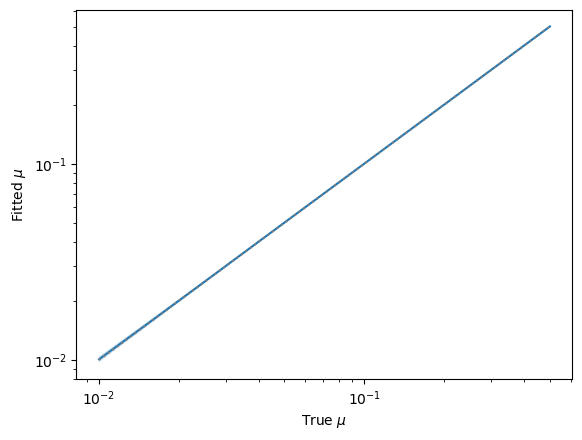

In [112]:
demo.plot_mu_hat(mu_hat_data, title='1D Gaussian Case')

Confidence interval for $\mu$

In [113]:
seed = 2024
N_B = 100_000
mu_inj = 0.01
mu_scan_list = np.arange(0.008, 0.013, 0.00001)

x, y= demo.get_dataset(N_B=N_B, mu_inj=mu_inj, seed=seed)
loss_data = demo.loss_scan(x, y, mu_scan_list, metric='nll')

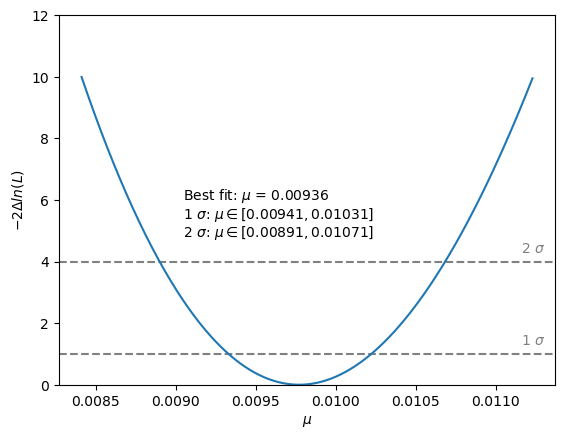

In [114]:
demo.plot_interval(loss_data, title='1D Gaussian Case')

In [116]:
# compare 1 sigma quantiles to random realization of data
np.quantile(mu_hat_data[0.01], [0.159, 0.841])

array([0.00966759, 0.01044801])

### Analytic Distributions - 3D Gaussian (Uncorrelated)

In [131]:
seed = 2024
mu_S = [1, 3, 5]
mu_B = [6, 4, 2]
sigma = 1

model_S = multivariate_normal(mean=mu_S, cov=sigma, seed=seed)
model_B = multivariate_normal(mean=mu_B, cov=sigma, seed=seed)

demo = Demonstrator(model_S=model_S, model_B=model_B)

Maximum likelihood estimate for $\mu$

In [132]:
mu_inj_list = np.logspace(-2, -0.3, 10)
N_trial = 20
N_B = 200_000

mu_hat_data = demo.scan_mu_hat(mu_inj_list, N_B=N_B, N_trial=N_trial, metric='nll', max_workers=24)

Running trial 1 with mu = 0.01
Running trial 2 with mu = 0.01
Running trial 3 with mu = 0.01
Running trial 4 with mu = 0.01
Running trial 5 with mu = 0.01
Running trial 6 with mu = 0.01
Running trial 7 with mu = 0.01
Running trial 8 with mu = 0.01
Running trial 9 with mu = 0.01
Running trial 10 with mu = 0.01
Running trial 11 with mu = 0.01
Running trial 12 with mu = 0.01
Running trial 13 with mu = 0.01
Running trial 14 with mu = 0.01
Running trial 15 with mu = 0.01
Running trial 16 with mu = 0.01
Running trial 17 with mu = 0.01
Running trial 18 with mu = 0.01
Running trial 19 with mu = 0.01
Running trial 20 with mu = 0.01
Running trial 1 with mu = 0.015448591479026755
Running trial 2 with mu = 0.015448591479026755
Running trial 3 with mu = 0.015448591479026755
Running trial 4 with mu = 0.015448591479026755


/tmp/ipykernel_1786769/3620834359.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3620834359.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3620834359.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3620834359.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3620834359.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; default

Running trial 5 with mu = 0.015448591479026755
Running trial 6 with mu = 0.015448591479026755
Running trial 7 with mu = 0.015448591479026755
Running trial 8 with mu = 0.015448591479026755
Running trial 9 with mu = 0.015448591479026755
Running trial 10 with mu = 0.015448591479026755
Running trial 11 with mu = 0.015448591479026755
Running trial 12 with mu = 0.015448591479026755
Running trial 15 with mu = 0.015448591479026755
Running trial 14 with mu = 0.015448591479026755
Running trial 13 with mu = 0.015448591479026755
Running trial 16 with mu = 0.015448591479026755
Running trial 17 with mu = 0.015448591479026755
Running trial 18 with mu = 0.015448591479026755
Running trial 19 with mu = 0.015448591479026755
Running trial 20 with mu = 0.015448591479026755
Running trial 1 with mu = 0.023865897868585808
Running trial 2 with mu = 0.023865897868585808
Running trial 3 with mu = 0.023865897868585808
Running trial 4 with mu = 0.023865897868585808
Running trial 5 with mu = 0.023865897868585808
Ru

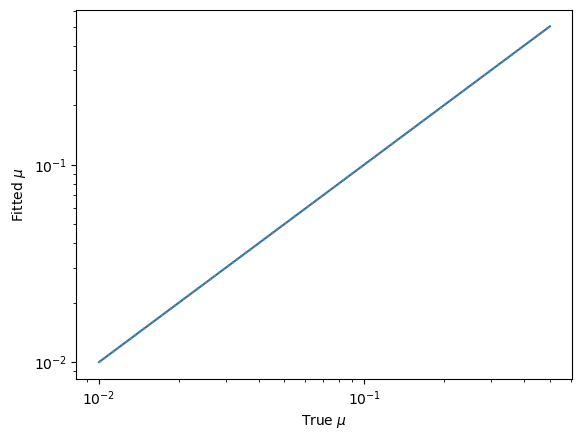

In [119]:
demo.plot_mu_hat(mu_hat_data, title='3D Gaussian Case')

Confidence interval for $\mu$

In [128]:
seed = 2024
N_B = 200_000
mu_inj = 0.01
mu_scan_list = np.arange(0.008, 0.013, 0.00001)

x, y= demo.get_dataset(N_B=N_B, mu_inj=mu_inj, seed=seed)
loss_data = demo.loss_scan(x, y, mu_scan_list, metric='nll')

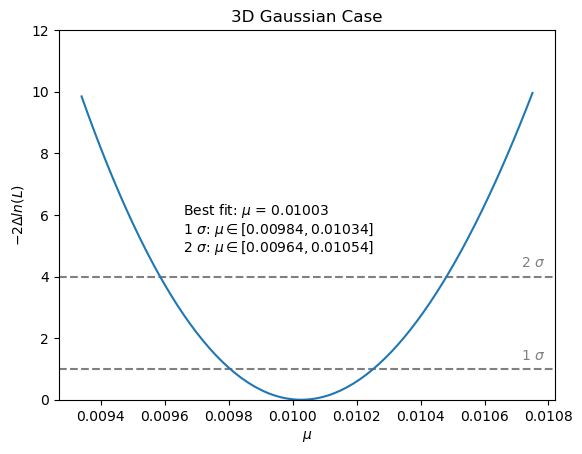

In [129]:
demo.plot_interval(loss_data, title='3D Gaussian Case')

In [133]:
# compare 1 sigma quantiles to random realization of data
np.quantile(mu_hat_data[0.01], [0.159, 0.841])

array([0.00998045, 0.01003579])

### Analytic Distributions - 2D Gaussian (Correlated)

In [134]:
seed = 2024

mu_S = [1, 3]
mu_B = [1.5, 3.5]
cov_S = np.array([[5, 4.5], [4.5, 5]]) # High Positive Correlation
cov_B = np.array([[3, -2.7], [-2.7, 3]]) # Positive Correlation
sigma = 1

model_S = multivariate_normal(mean=mu_S, cov=cov_S, seed=seed)
model_B = multivariate_normal(mean=mu_B, cov=cov_B, seed=seed)

demo = Demonstrator(model_S=model_S, model_B=model_B)

Maximum likelihood estimate for $\mu$

In [135]:
mu_inj_list = np.logspace(-2, -0.3, 10)
N_trial = 20
N_B = 200_000

mu_hat_data = demo.scan_mu_hat(mu_inj_list, N_B=N_B, N_trial=N_trial, metric='nll', max_workers=24)

Running trial 1 with mu = 0.01
Running trial 2 with mu = 0.01
Running trial 3 with mu = 0.01
Running trial 4 with mu = 0.01
Running trial 5 with mu = 0.01
Running trial 6 with mu = 0.01
Running trial 7 with mu = 0.01
Running trial 8 with mu = 0.01
Running trial 9 with mu = 0.01
Running trial 10 with mu = 0.01
Running trial 11 with mu = 0.01
Running trial 12 with mu = 0.01
Running trial 13 with mu = 0.01
Running trial 14 with mu = 0.01
Running trial 15 with mu = 0.01
Running trial 16 with mu = 0.01
Running trial 17 with mu = 0.01
Running trial 19 with mu = 0.01
Running trial 18 with mu = 0.01
Running trial 20 with mu = 0.01
Running trial 1 with mu = 0.015448591479026755
Running trial 2 with mu = 0.015448591479026755
Running trial 3 with mu = 0.015448591479026755
Running trial 4 with mu = 0.015448591479026755


/tmp/ipykernel_1786769/3620834359.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3620834359.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3620834359.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3620834359.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/3620834359.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; default

Running trial 5 with mu = 0.015448591479026755
Running trial 6 with mu = 0.015448591479026755
Running trial 7 with mu = 0.015448591479026755
Running trial 8 with mu = 0.015448591479026755
Running trial 10 with mu = 0.015448591479026755
Running trial 9 with mu = 0.015448591479026755
Running trial 11 with mu = 0.015448591479026755
Running trial 12 with mu = 0.015448591479026755
Running trial 13 with mu = 0.015448591479026755
Running trial 14 with mu = 0.015448591479026755
Running trial 15 with mu = 0.015448591479026755
Running trial 16 with mu = 0.015448591479026755
Running trial 17 with mu = 0.015448591479026755
Running trial 18 with mu = 0.015448591479026755
Running trial 19 with mu = 0.015448591479026755
Running trial 20 with mu = 0.015448591479026755
Running trial 1 with mu = 0.023865897868585808
Running trial 2 with mu = 0.023865897868585808
Running trial 3 with mu = 0.023865897868585808
Running trial 4 with mu = 0.023865897868585808
Running trial 5 with mu = 0.023865897868585808
Ru

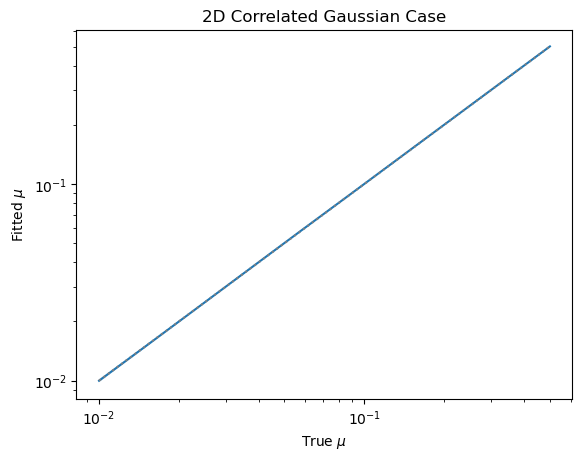

In [136]:
demo.plot_mu_hat(mu_hat_data, title='2D Correlated Gaussian Case')

Confidence interval for $\mu$

In [137]:
seed = 2024
N_B = 200_000
mu_inj = 0.01
mu_scan_list = np.arange(0.008, 0.013, 0.00001)

x, y= demo.get_dataset(N_B=N_B, mu_inj=mu_inj, seed=seed)
loss_data = demo.loss_scan(x, y, mu_scan_list, metric='nll')

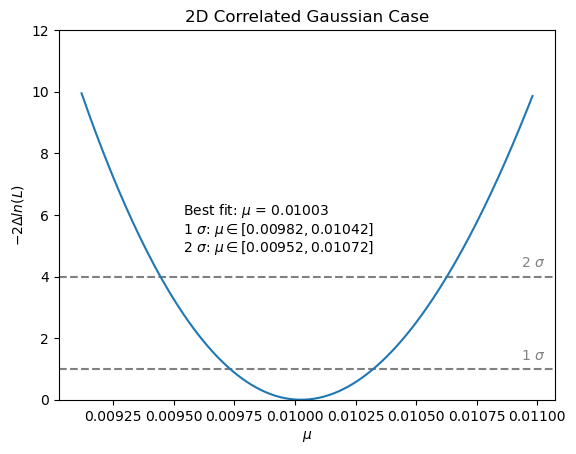

In [138]:
demo.plot_interval(loss_data, title='2D Correlated Gaussian Case')

In [139]:
# compare 1 sigma quantiles to random realization of data
np.quantile(mu_hat_data[0.01], [0.159, 0.841])

array([0.00976698, 0.01018778])

### Analytic Distributions -  2D Gaussian Signal + Exponential Background Case

In [140]:
class DistributionModel:
    def __init__(self, seed=None):
        self.seed = seed
        self.random_state = np.random.RandomState(seed) if seed is not None else None

    def rvs(self, size):
        raise NotImplementedError

class ExponentialModel(DistributionModel):
    def __init__(self, scale, seed=None):
        super().__init__(seed)
        self.scale = scale

    def rvs(self, size, random_state=None):
        random_state = random_state or self.random_state
        return expon(scale=self.scale).rvs(size=(size, 2), random_state=random_state)

    def pdf(self, x):
        # The PDF of the exponential distribution for each independent variable:
        # f(x) = (1 / scale) * exp(-x / scale) for x > 0
        # In 2D, assuming independence, the joint PDF is the product of the marginal PDFs.
        pdf_x1 = (1 / self.scale) * np.exp(-x[:, 0] / self.scale)
        pdf_x2 = (1 / self.scale) * np.exp(-x[:, 1] / self.scale)
        return pdf_x1 * pdf_x2

In [142]:
seed = 2024

mu_S = [3, 3]
cov_S = np.array([[1, 0], [0, 1]])
model_S = multivariate_normal(mean=mu_S, cov=cov_S, seed=seed)

scale_B = (10 - 1) / np.log(10)
model_B = ExponentialModel(scale=scale_B, seed=seed)

demo = Demonstrator(model_S=model_S, model_B=model_B)

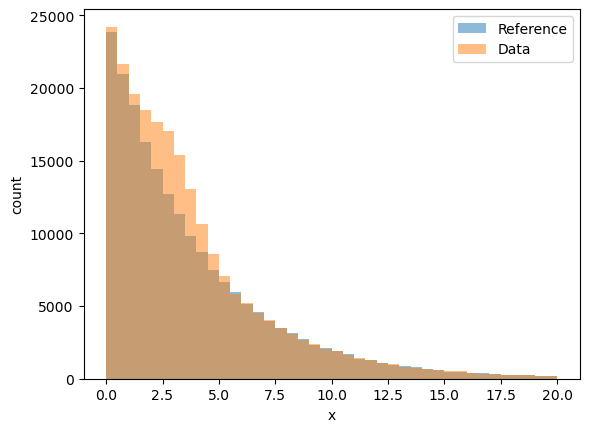

In [143]:
N_B = 200000
R = demo.get_R(N_B)
D = demo.get_D(N_B, mu_inj=0.1)
demo.plot_distribution(D, R, feature_index=0)

Maximum likelihood estimate for $\mu$

In [144]:
mu_inj_list = np.logspace(-2, -0.3, 10)
N_trial = 20
N_B = 200_000

mu_hat_data = demo.scan_mu_hat(mu_inj_list, N_B=N_B, N_trial=N_trial, metric='nll', max_workers=24)

Running trial 1 with mu = 0.01
Running trial 3 with mu = 0.01
Running trial 2 with mu = 0.01
Running trial 4 with mu = 0.01
Running trial 6 with mu = 0.01
Running trial 5 with mu = 0.01
Running trial 7 with mu = 0.01
Running trial 8 with mu = 0.01
Running trial 9 with mu = 0.01
Running trial 10 with mu = 0.01
Running trial 11 with mu = 0.01
Running trial 13 with mu = 0.01
Running trial 12 with mu = 0.01
Running trial 14 with mu = 0.01
Running trial 15 with mu = 0.01
Running trial 16 with mu = 0.01
Running trial 17 with mu = 0.01
Running trial 18 with mu = 0.01
Running trial 19 with mu = 0.01
Running trial 20 with mu = 0.01
Running trial 1 with mu = 0.015448591479026755
Running trial 2 with mu = 0.015448591479026755
Running trial 3 with mu = 0.015448591479026755
Running trial 4 with mu = 0.015448591479026755


/tmp/ipykernel_1786769/4256952965.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/4256952965.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/4256952965.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/4256952965.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  result = minimize_scalar(func, bounds=(1e-6, 1 - 1e-6), tol=1e-6)
/tmp/ipykernel_1786769/4256952965.py:112: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; default

Running trial 5 with mu = 0.015448591479026755
Running trial 6 with mu = 0.015448591479026755
Running trial 7 with mu = 0.015448591479026755
Running trial 8 with mu = 0.015448591479026755
Running trial 9 with mu = 0.015448591479026755
Running trial 10 with mu = 0.015448591479026755
Running trial 11 with mu = 0.015448591479026755
Running trial 12 with mu = 0.015448591479026755
Running trial 13 with mu = 0.015448591479026755
Running trial 14 with mu = 0.015448591479026755
Running trial 15 with mu = 0.015448591479026755
Running trial 16 with mu = 0.015448591479026755
Running trial 17 with mu = 0.015448591479026755
Running trial 18 with mu = 0.015448591479026755
Running trial 19 with mu = 0.015448591479026755
Running trial 20 with mu = 0.015448591479026755
Running trial 1 with mu = 0.023865897868585808
Running trial 2 with mu = 0.023865897868585808
Running trial 3 with mu = 0.023865897868585808
Running trial 4 with mu = 0.023865897868585808
Running trial 5 with mu = 0.023865897868585808
Ru

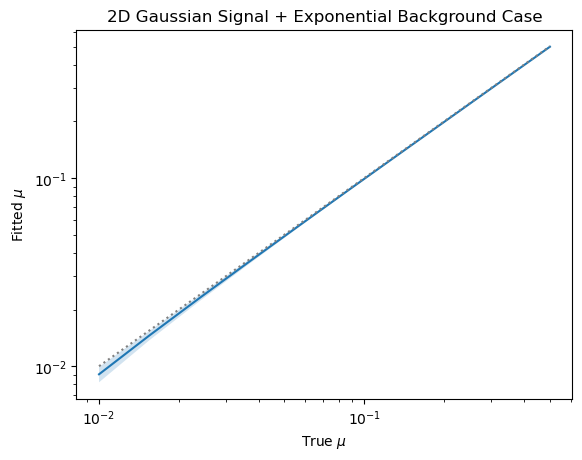

In [145]:
demo.plot_mu_hat(mu_hat_data, title='2D Gaussian Signal + Exponential Background Case')

Confidence interval for $\mu$

In [146]:
seed = 2024
N_B = 200_000
mu_inj = 0.01
mu_scan_list = np.arange(0.008, 0.013, 0.00001)

x, y= demo.get_dataset(N_B=N_B, mu_inj=mu_inj, seed=seed)
loss_data = demo.loss_scan(x, y, mu_scan_list, metric='nll')

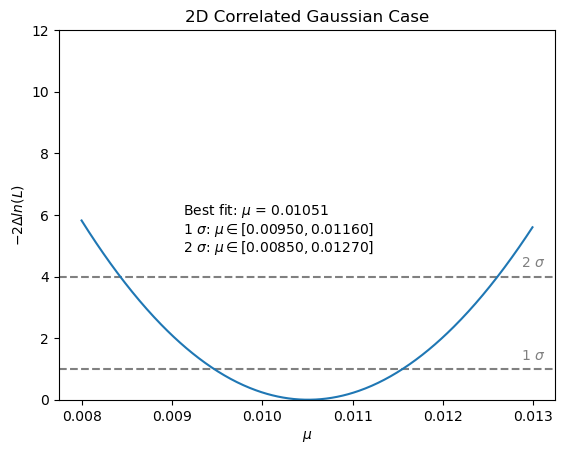

In [147]:
demo.plot_interval(loss_data, title='2D Correlated Gaussian Case')

In [148]:
# compare 1 sigma quantiles to random realization of data
np.quantile(mu_hat_data[0.01], [0.159, 0.841])

array([0.00800724, 0.01001644])

## Model Training

In [149]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal, expon
import matplotlib.pyplot as plt

seed = 2024

# Signal (S): 2D Gaussian with slight correlation
mu_S = [3, 3]
cov_S = np.array([[1.0, 0.5], [0.5, 1.0]])  # Slight correlation
N_S = 100_000  # 100k signals

# Background (B): 2D Exponential, no correlation
scale_B = (10 - 1) / np.log(10)
N_B = 1_000_000  # 1M backgrounds

# Generate the signal and background samples
signal_data = multivariate_normal(mean=mu_S, cov=cov_S).rvs(size=N_S)
background_data = expon(scale=scale_B).rvs(size=(N_B, 2))

signal_labels = np.ones(N_S)  
background_labels = np.zeros(N_B) 

X = np.concatenate([signal_data, background_data], axis=0)
y = np.concatenate([signal_labels, background_labels], axis=0)

# 2. Split into train, validation, and test datasets (50%, 25%, 25%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

2024-10-14 19:32:15.713678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 19:32:15.714702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 19:32:15.809336: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 19:32:16.061625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 19:32:18.577129: W tensorflow/compiler/tf2

Train supervised model

In [150]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,        
    restore_best_weights=True
)

2024-10-14 19:32:22.777260: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [151]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Set a large number of epochs, early stopping will handle when to stop
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/100
4297/4297 [==============================] - 5s 1ms/step - loss: 0.1961 - accuracy: 0.9097 - val_loss: 0.1826 - val_accuracy: 0.9128
Epoch 2/100
4297/4297 [==============================] - 4s 949us/step - loss: 0.1826 - accuracy: 0.9131 - val_loss: 0.1808 - val_accuracy: 0.9136
Epoch 3/100
4297/4297 [==============================] - 4s 991us/step - loss: 0.1821 - accuracy: 0.9131 - val_loss: 0.1804 - val_accuracy: 0.9142
Epoch 4/100
4297/4297 [==============================] - 4s 999us/step - loss: 0.1818 - accuracy: 0.9131 - val_loss: 0.1803 - val_accuracy: 0.9142
Epoch 5/100
4297/4297 [==============================] - 4s 981us/step - loss: 0.1816 - accuracy: 0.9135 - val_loss: 0.1808 - val_accuracy: 0.9139
Epoch 6/100
4297/4297 [==============================] - 4s 948us/step - loss: 0.1815 - accuracy: 0.9133 - val_loss: 0.1803 - val_accuracy: 0.9143
Epoch 7/100
4297/4297 [==============================] - 4s 1ms/step - loss: 0.1814 - accuracy: 0.9133 - val_loss: 0.180

In [152]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

8594/8594 [==============================] - 4s 512us/step - loss: 0.1811 - accuracy: 0.9136
Test Accuracy: 91.36%


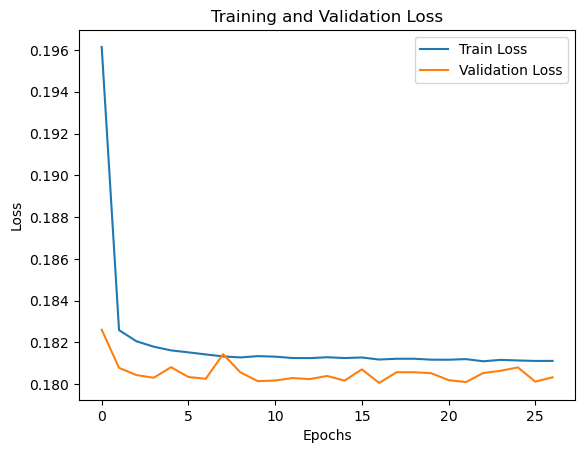

In [153]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [154]:
# Craete weakly datasets

S_test = X_test[y_test == 1]
B_test = X_test[y_test == 0] 

mu = 0.1
N_B = 100_000
N_S = int(mu / (1 - mu) * N_B)

D = np.concatenate([S_test[:N_S], B_test[:N_B]], axis=0)
R = B_test[N_B : 2 * N_B]

Text(0.5, 0, 'x')

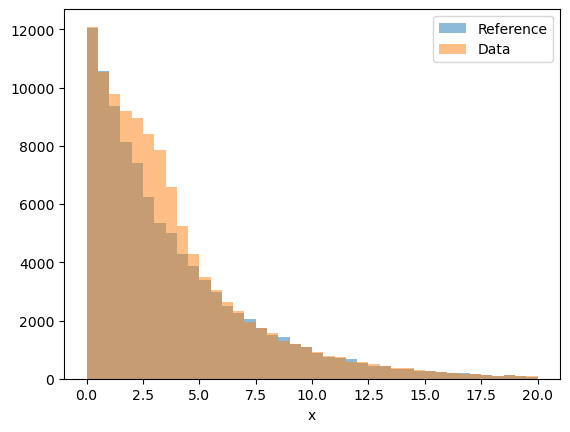

In [155]:
plt.hist(R[:, 0], alpha=0.5, range=(0, 20), bins=40, label='Reference')
plt.hist(D[:, 0], alpha=0.5, range=(0, 20), bins=40, label='Data')
plt.legend()
plt.xlabel('x')

In [156]:
FS_ref = model.predict(R).flatten()
kappa = 1 / np.mean(FS_ref / (1 - FS_ref))

3125/3125 [==============================] - 2s 470us/step


In [157]:
kappa

10.262315713689544

In [201]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from keras import backend
from keras.src.losses import LossFunctionWrapper

class MinMaxRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, min_val, max_val, l=1.0):
      self.min_val = min_val
      self.max_val = max_val
      self.l = l

  def __call__(self, x):
      x_under = tf.cast(tf.less(x, self.min_val), dtype=tf.float32)
      x_over  = tf.cast(tf.greater(x, self.max_val), dtype=tf.float32)
      under_penalty = (tf.exp(self.min_val - x) - 1)
      over_penalty = (tf.exp(x - self.max_val) - 1)
      penalty = self.l * tf.math.reduce_sum(((x_under * under_penalty) + (x_over * over_penalty)))
      return penalty

  def get_config(self):
      return {'l': float(self.l),
              'min_val': float(self.min_val),
              'max_val': float(self.max_val)}

def nll_loss(y_true, y_pred, axis=-1):
    """Computes the negative log-likelihood loss.

    Args:
        y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
        y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.
        axis: The axis along which the mean is computed. Defaults to `-1`.

    Returns:
        Scaled negative log-likelihood loss value. shape = `[batch_size, d0, .. dN-1]`.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    nll = - y_true * (tf.math.log(y_pred))
    return backend.mean(nll, axis=axis)

class NLLLoss(LossFunctionWrapper):
    """
    Custom loss function that applies an offset and scaling to the negative log-likelihood loss.

    Args:
        offset (float): The offset to be added to the binary cross-entropy loss. Default is 0.0.
        scale (float): The scaling factor to be applied to the (binary cross-entropy loss + offset). Default is 1.0.
        from_logits (bool): Whether `y_pred` is expected to be a logits tensor. By default, we assume that `y_pred` 
                            encodes a probability distribution. Default is False.
        label_smoothing (float): Float in [0, 1]. When 0, no smoothing occurs. When > 0, we compute the loss between
                                 the predicted labels and a smoothed version of the true labels, where the smoothing 
                                 squeezes the labels towards 0.5. Default is 0.
        axis (int): The axis along which to compute maximum likelihood. Default is -1.
        **kwargs: Additional keyword arguments for the base class.
    """

    def __init__(
        self,
        axis=-1,
        reduction="sum_over_batch_size",
        name="scaled_maximum_likelihood",
    ):
        super().__init__(
            nll_loss,
            name=name,
            reduction=reduction,
            axis=axis,
        )
        self.axis = axis

    @classmethod
    def from_config(cls, config):
        config.pop("fn", None)
        return cls(**config)    

    def get_config(self):
        return {
            "name": self.name,
            "reduction": self.reduction,
            "axis": self.axis,
        }

def get_single_parameter_model(default,
                               name = None,
                               exponential=False,
                               regularizer=None):
    inputs = Input(shape=(1,))
    outputs = Dense(1, use_bias=False,
                    kernel_initializer=tf.constant_initializer(float(default)),
                    kernel_regularizer=regularizer,
                    activation='linear',
                    name=name)(inputs)
    if exponential:
        outputs = tf.exp(outputs)
    return Model(inputs=inputs, outputs=outputs)

def create_ws_model(fs_model, feature_dim, kappa=1.0):
    x = Input(shape=(feature_dim,))
    fs_out = fs_model(x)
    mu_input = get_single_parameter_model(-4., name='mu',
                                          exponential=True,
                                          regularizer=MinMaxRegularizer(-10.0, 0.0),)
    mu_out = mu_input(tf.ones_like(x)[:, :1])
    lambda_FS = fs_out / (1 - fs_out + 1e-5)
    if kappa == 'trainable':
        kappa_input = get_single_parameter_model(5., name='kappa',
                                                 exponential=False,
                                                 regularizer=MinMaxRegularizer(1, 30))
        kappa = kappa_input(tf.ones_like(x)[:, :1])
    likelihood_out = mu_out * lambda_FS * kappa + 1 - mu_out
    ws_model = tf.keras.Model(inputs=x, outputs=likelihood_out, name='SemiWeaklyLikelihood')
    return ws_model

In [202]:
# Craete weakly datasets

S_test = X_test[y_test == 1]
B_test = X_test[y_test == 0]

N_B = 100000
mu = 0.01
N_S = int(mu / (1 - mu) * N_B)

D = np.concatenate([S_test[:N_S], B_test[:N_B]], axis=0)
R = B_test[N_B : 2 * N_B]

X = np.concatenate([D, R])
Y = np.concatenate([np.ones(D.shape[0]), np.zeros(R.shape[0])])

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.5, random_state=2024)

In [203]:
for layer in model.layers:
    layer.trainable = False

In [204]:
ws_model = create_ws_model(model, feature_dim=2, kappa=kappa)
loss_fn = NLLLoss()
ws_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [205]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,        
    restore_best_weights=True
)

ws_model.fit(x_train, y_train,
             validation_data=(x_val, y_val),
             epochs=1000,
             batch_size=1024,
             callbacks=[early_stopping])

Epoch 1/1000
99/99 [==============================] - 1s 3ms/step - loss: -1.8212e-04 - accuracy: 0.5035 - val_loss: -1.0294e-04 - val_accuracy: 0.5015
Epoch 2/1000
99/99 [==============================] - 0s 2ms/step - loss: -1.8846e-04 - accuracy: 0.5035 - val_loss: -1.1378e-04 - val_accuracy: 0.5015
Epoch 3/1000
99/99 [==============================] - 0s 3ms/step - loss: -1.9412e-04 - accuracy: 0.5035 - val_loss: -1.2223e-04 - val_accuracy: 0.5015
Epoch 4/1000
99/99 [==============================] - 0s 3ms/step - loss: -1.9802e-04 - accuracy: 0.5035 - val_loss: -1.2744e-04 - val_accuracy: 0.5015
Epoch 5/1000
99/99 [==============================] - 0s 2ms/step - loss: -2.0153e-04 - accuracy: 0.5035 - val_loss: -1.3406e-04 - val_accuracy: 0.5015
Epoch 6/1000
99/99 [==============================] - 0s 2ms/step - loss: -2.0407e-04 - accuracy: 0.5035 - val_loss: -1.3757e-04 - val_accuracy: 0.5015
Epoch 7/1000
99/99 [==============================] - 0s 2ms/step - loss: -2.0610e-04 - 

In [206]:
weights = {}
for weight in ws_model.trainable_weights:
    name = weight.name.split('/')[0]
    weights[name] = weight[0][0]
print(f'predicted mu: {np.exp(weights["mu"])}')
print(f'truth mu: {mu}')

predicted mu: 0.012319926172494888
truth mu: 0.01
